In [156]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import featuretools as ft
from sklearn.preprocessing import OneHotEncoder
import optuna
from sklearn.metrics import f1_score,precision_score, recall_score
import catboost as cb
from sklearn.metrics import fbeta_score, make_scorer
from scipy.special import expit


In [157]:
df = pd.read_csv(r'C:\Users\Egor\Desktop\Machine Learning\datasets\heart.csv')
df_saturation = pd.read_csv(r'C:\Users\Egor\Desktop\Machine Learning\datasets\o2Saturation.csv')

Dataset Description:
--------------------
Задача понравилась мне потому что она показалась мне одновременно сложной из-за описанных выше трудностей, так и полезной, так как сама концепция разработки модели, которая могла бы в перспективе принести пользу обществу, привлекает меня.

- Age: Возраст пациента
- Sex: Пол пациента
- exng: Стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)
- ca: Количество крупных сосудов (0-3)
- cp: Тип боли в грудной клетке
  - Value 1: типичная стенокардия
  - Value 2: атипичная стенокардия
  - Value 3: неангинальная боль
  - Value 4: бессимптомная
- trtbps: Артериальное давление в покое (в мм рт. ст.)
- chol: Уровень холестерина в мг/дл
- fbs: Сахар в крови натощак (1 = истина; 0 = ложь)
- restecg: Результаты электрокардиографии в состоянии покоя
  - Value 0: норма
  - Value 1: наличие аномалии ST-T
  - Value 2: вероятная или определенная гипертрофия левого желудочка
- thalach: Максимальная достигнутая частота сердечных сокращений
- output: Вероятность сердечного приступа (0 = меньше вероятность, 1 = больше вероятность)

## Preprocessing Steps to Consider:
   
### 1. Анализ данных:
   - Изучение распределения данных
   - Проверка наличия выбросов
   - Проверка корреляции между данными
   - Обработка отсутствующих значений

### 2. Выбор основной метрики:
   - Основная метрика: f_beta_score, где beta=2
   - Обоснование выбора метрики:
     - Неравномерное распределение данных
     - Приоритет на минимизацию пропущенных случаев заболевания
     - Учёт ограниченных ресурсов для дополнительных обследований

### 3. Решение трудностей задачи:
   - Применение полиномиальных преобразований и библиотеки featuretools для увеличения зависимостей между признаками
   - Использование StratifiedKFold для создания репрезентативных выборок при кросс-валидации
   - Использование оптимизации optuna вместо GridSearch из-за большого количества комбинаций признаков
   - Обнаружение и устранение утечки данных, что приводило к необычно высокому f1

### 4. Результаты:
   - Достигнутые метрики: precision 0.9 и recall 0.93
   - Обоснование хороших результатов:
     - Они соответствуют изначально поставленной цели, учитывая их высокое значение и сбалансированное соотношение между собой.


In [158]:
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [159]:
display(df_saturation.head())
display(df_saturation.shape)

,98.6
0,98.6
1,98.6
2,98.6
3,98.1
4,97.5


(3585, 1)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [161]:
df.isnull().sum()


age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [162]:
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]
print("The categorial cols are : ", cat_cols)
print("The continuous cols are : ", con_cols)
print("The target variable is :  ", target_col)

The categorial cols are :  ['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']
The continuous cols are :  ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
The target variable is :   ['output']


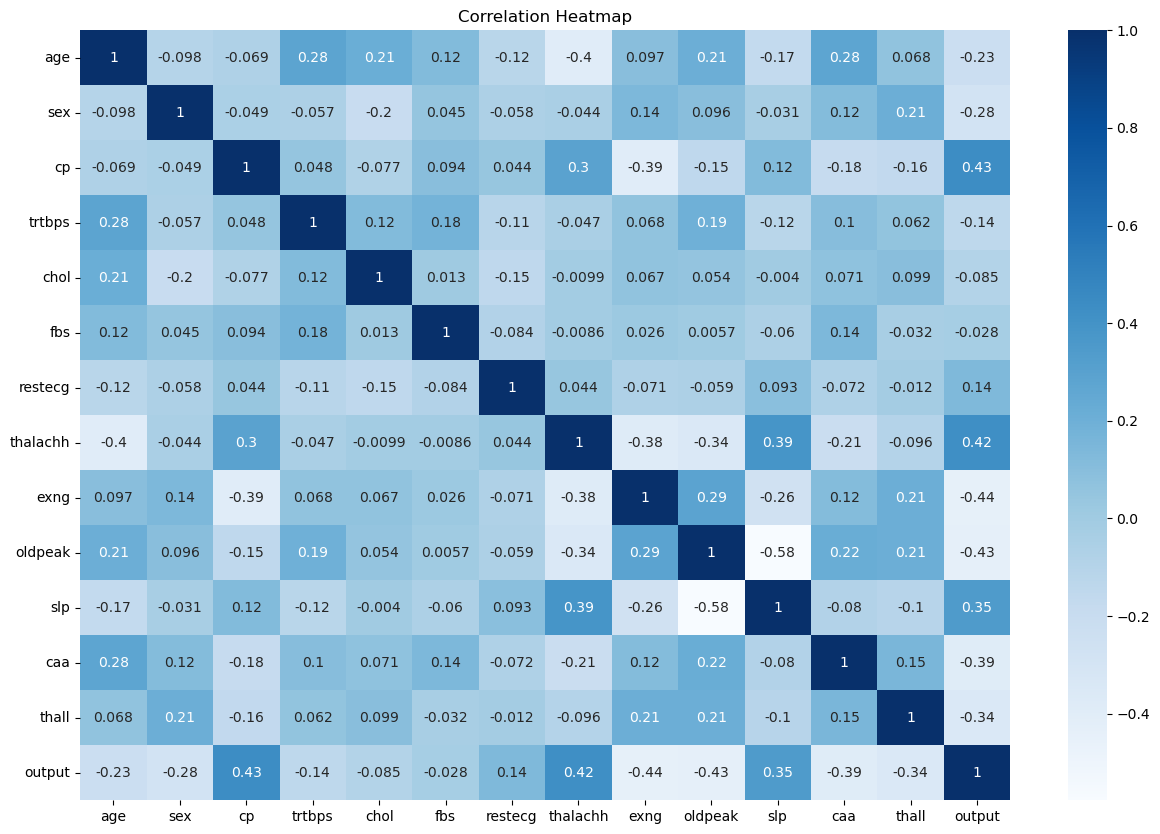

In [163]:
df_corr = df[con_cols].corr().transpose()
data = df.drop("output",axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()

<Figure size 1800x1200 with 0 Axes>

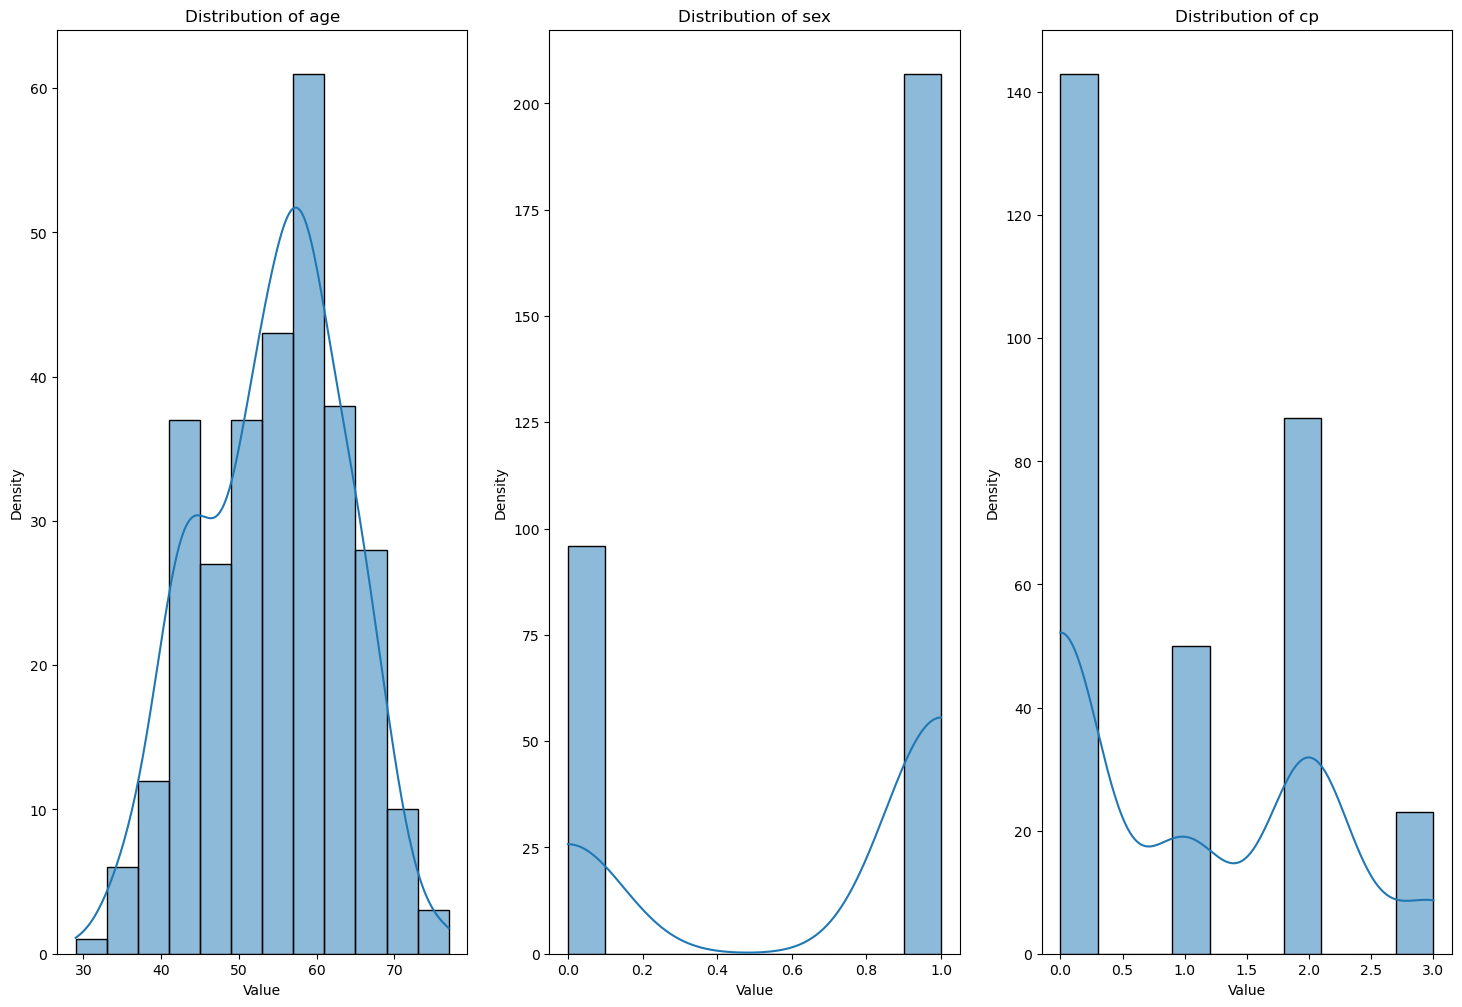

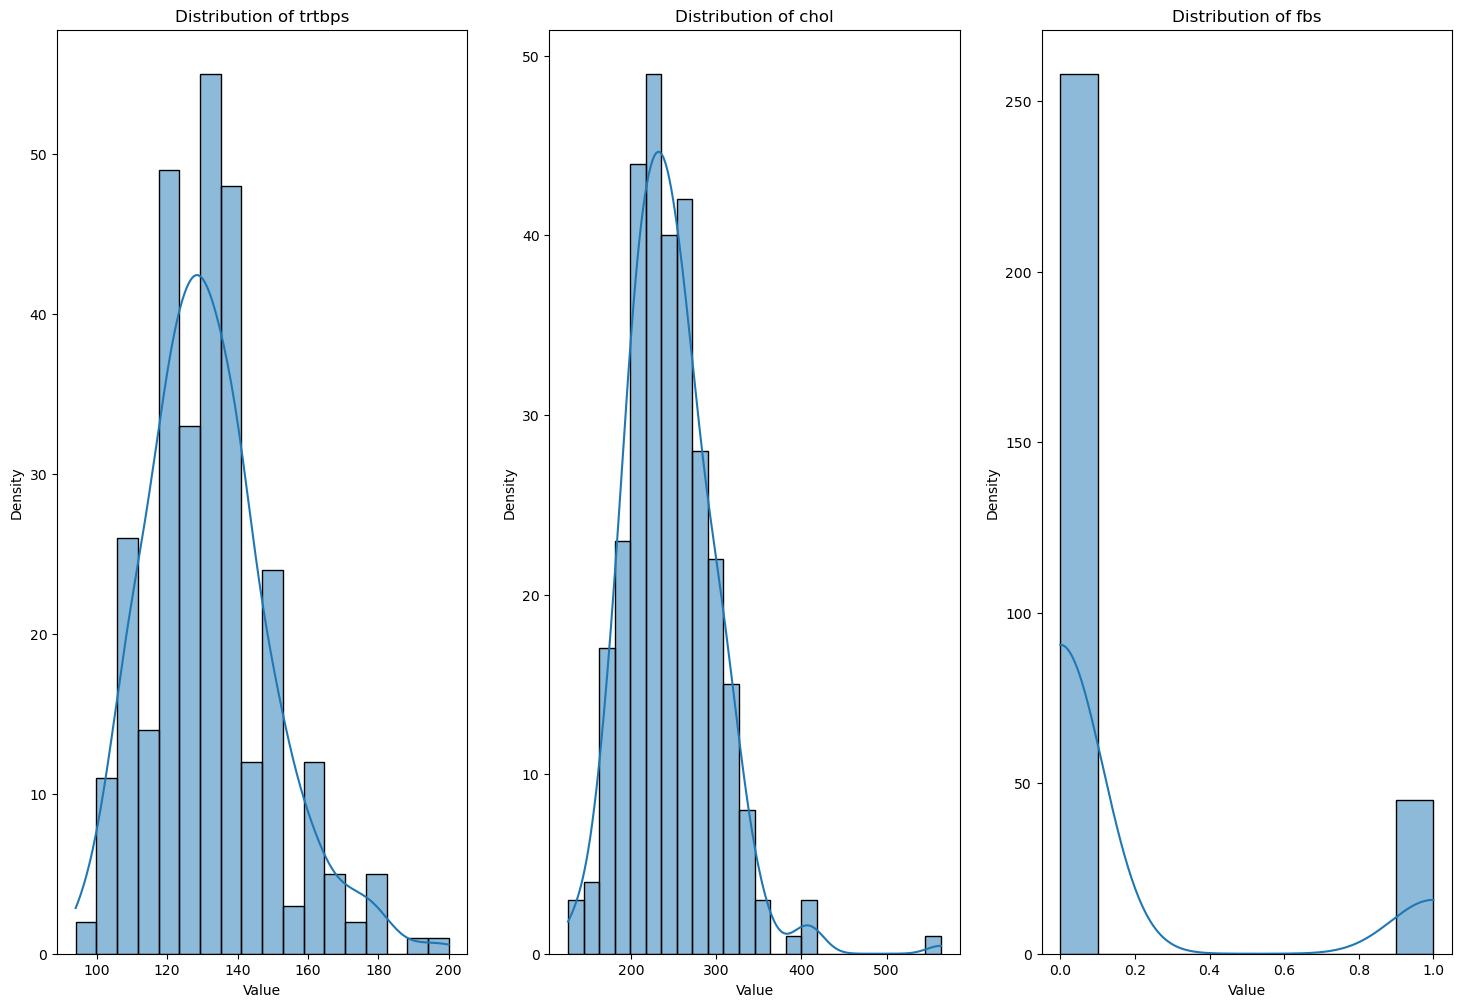

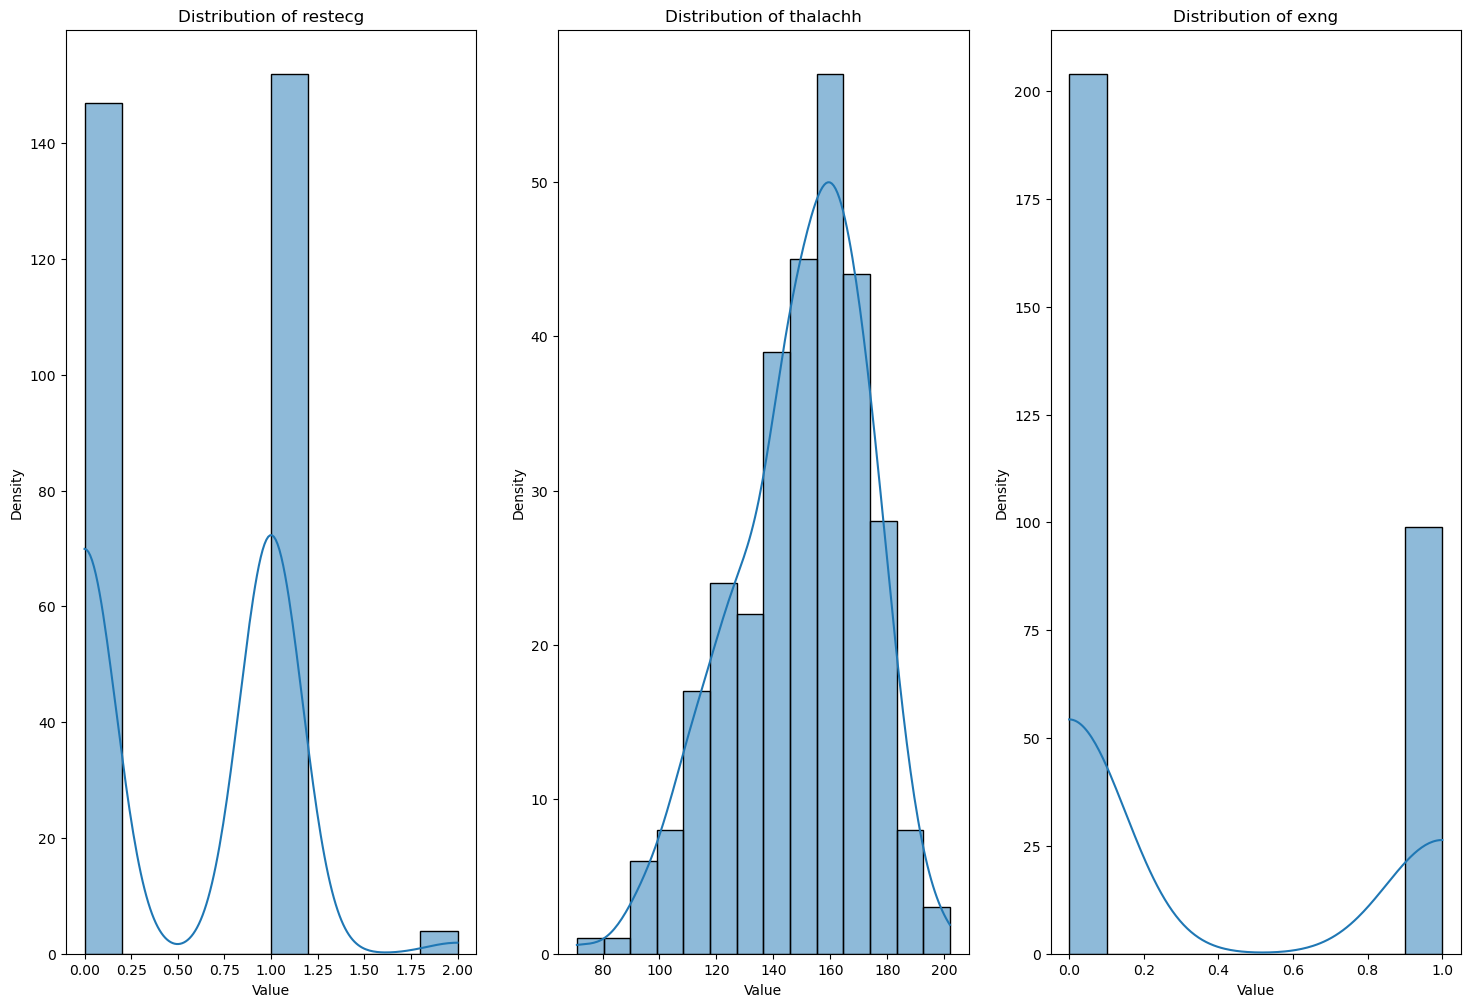

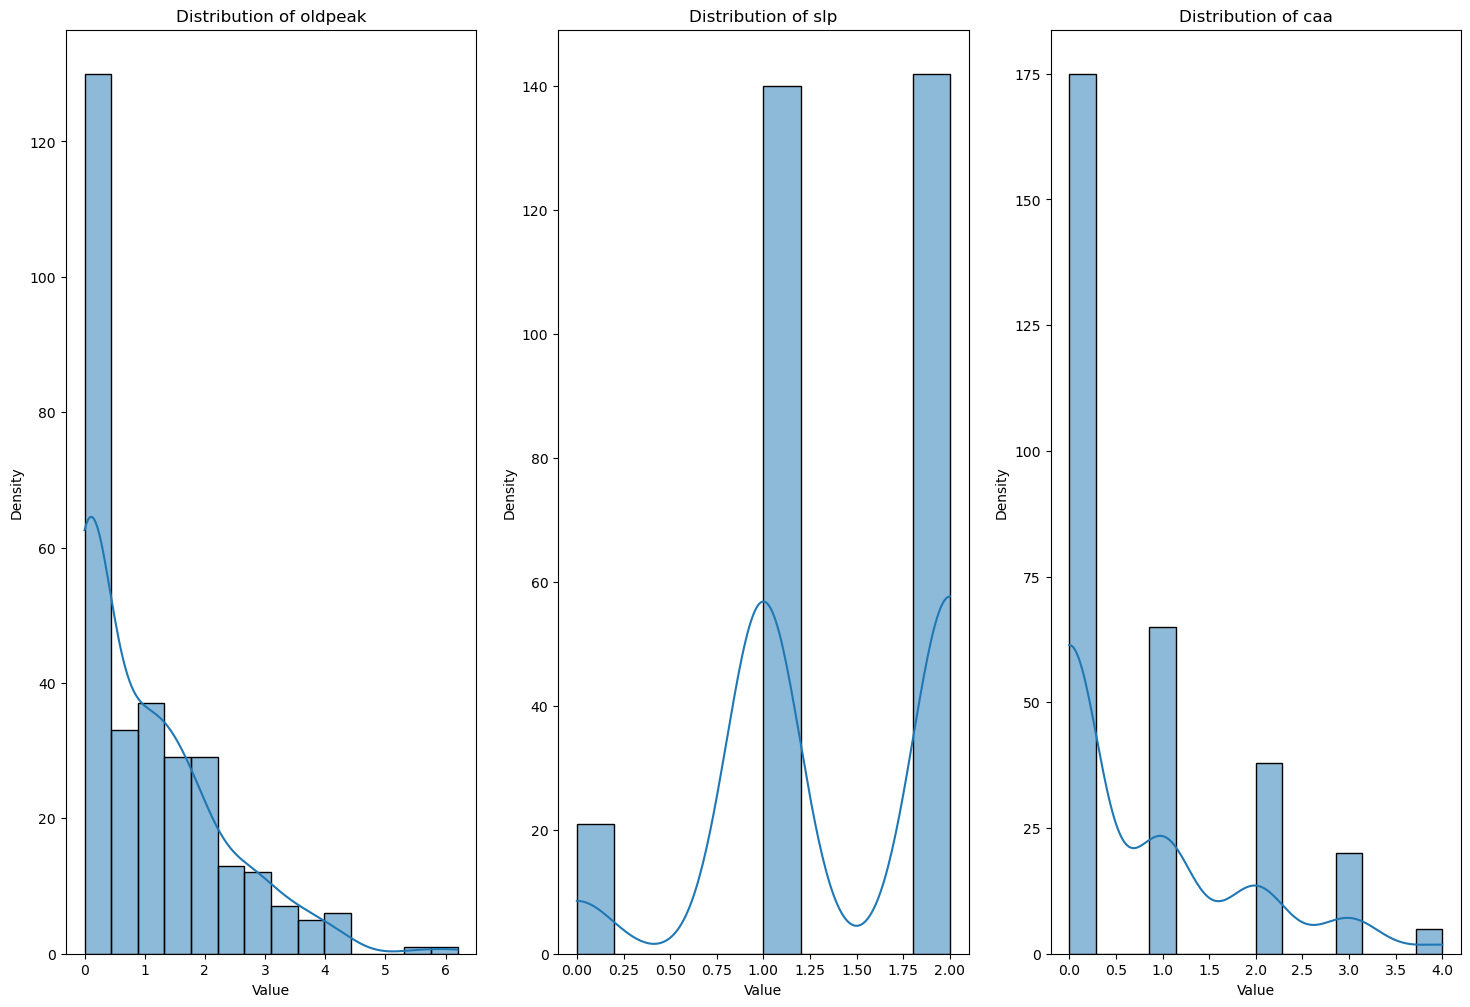

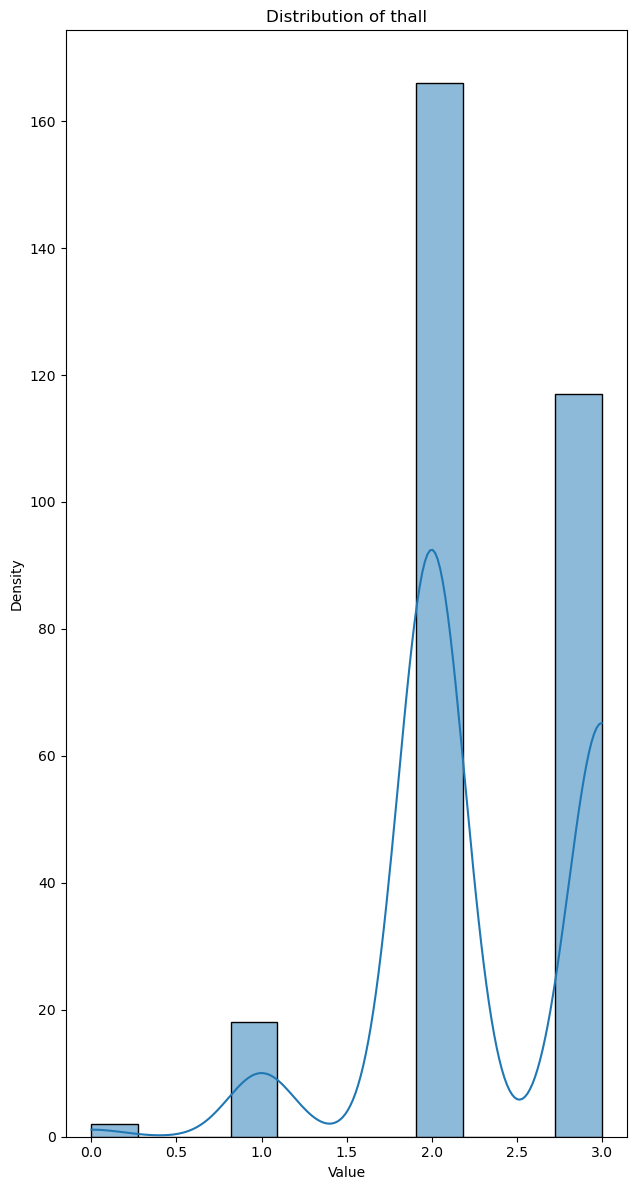

In [164]:
plt.figure(figsize=(18, 12))
features = df.drop('output', axis=1).columns

for i, feature in enumerate(features):
    if i % 3 == 0:  
        plt.figure(figsize=(18, 12))  
    plt.subplot(1, 3, i % 3 + 1)  
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Value')
    plt.ylabel('Density')

plt.tight_layout()  
plt.show()


Смотрим на распределение фичей, видим, что по некоторым фичам оно сильно неравномерное, попробуем StratifiedKFold

In [165]:
encoder = OneHotEncoder()

onehot_encoded = encoder.fit_transform(df[['cp', 'restecg']])
onehot_df = pd.DataFrame(onehot_encoded.toarray(), columns=encoder.get_feature_names_out(['cp', 'restecg']))
df = pd.concat([df, onehot_df], axis=1)
df.drop(columns=['cp', 'restecg'], inplace=True)

df


,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,output,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2
0,63,1,145,233,1,150,0,2.3,0,0,1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,37,1,130,250,0,187,0,3.5,0,0,2,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,41,0,130,204,0,172,0,1.4,2,0,2,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,56,1,120,236,0,178,0,0.8,2,0,2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,57,0,120,354,0,163,1,0.6,2,0,2,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,1,0,3,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
299,45,1,110,264,0,132,0,1.2,1,0,3,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
300,68,1,144,193,1,141,0,3.4,1,2,3,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
301,57,1,130,131,0,115,1,1.2,1,1,3,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [166]:
y = df['output']

In [167]:
es = ft.EntitySet(id = 'id')
es = es.add_dataframe(
      dataframe_name="data",
      dataframe=df.drop(['output'],axis=1),
      index="index",
)

c:\Users\Egor\anaconda3\Lib\site-packages\featuretools\entityset\entityset.py:1910: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(


In [168]:
X, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                      trans_primitives = ['add_numeric', 'multiply_numeric'],
                                       max_depth=1)

X.head()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,...,sex * slp,sex * thalachh,sex * thall,sex * trtbps,slp * thalachh,slp * thall,slp * trtbps,thalachh * thall,thalachh * trtbps,thall * trtbps
index,,,,,,,,,,,,,,,,,,,,,
0,63,1,145,233,1,150,0,2.3,0,0,...,0.0,150.0,1.0,145.0,0.0,0.0,0.0,150.0,21750.0,145.0
1,37,1,130,250,0,187,0,3.5,0,0,...,0.0,187.0,2.0,130.0,0.0,0.0,0.0,374.0,24310.0,260.0
2,41,0,130,204,0,172,0,1.4,2,0,...,0.0,0.0,0.0,0.0,344.0,4.0,260.0,344.0,22360.0,260.0
3,56,1,120,236,0,178,0,0.8,2,0,...,2.0,178.0,2.0,120.0,356.0,4.0,240.0,356.0,21360.0,240.0
4,57,0,120,354,0,163,1,0.6,2,0,...,0.0,0.0,0.0,0.0,326.0,4.0,240.0,326.0,19560.0,240.0


In [169]:
X.reset_index(drop=True,inplace=True)

In [170]:
X

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,...,sex * slp,sex * thalachh,sex * thall,sex * trtbps,slp * thalachh,slp * thall,slp * trtbps,thalachh * thall,thalachh * trtbps,thall * trtbps
0,63,1,145,233,1,150,0,2.3,0,0,...,0.0,150.0,1.0,145.0,0.0,0.0,0.0,150.0,21750.0,145.0
1,37,1,130,250,0,187,0,3.5,0,0,...,0.0,187.0,2.0,130.0,0.0,0.0,0.0,374.0,24310.0,260.0
2,41,0,130,204,0,172,0,1.4,2,0,...,0.0,0.0,0.0,0.0,344.0,4.0,260.0,344.0,22360.0,260.0
3,56,1,120,236,0,178,0,0.8,2,0,...,2.0,178.0,2.0,120.0,356.0,4.0,240.0,356.0,21360.0,240.0
4,57,0,120,354,0,163,1,0.6,2,0,...,0.0,0.0,0.0,0.0,326.0,4.0,240.0,326.0,19560.0,240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,1,0,...,0.0,0.0,0.0,0.0,123.0,3.0,140.0,369.0,17220.0,420.0
299,45,1,110,264,0,132,0,1.2,1,0,...,1.0,132.0,3.0,110.0,132.0,3.0,110.0,396.0,14520.0,330.0
300,68,1,144,193,1,141,0,3.4,1,2,...,1.0,141.0,3.0,144.0,141.0,3.0,144.0,423.0,20304.0,432.0
301,57,1,130,131,0,115,1,1.2,1,1,...,1.0,115.0,3.0,130.0,115.0,3.0,130.0,345.0,14950.0,390.0


In [171]:
poly = PolynomialFeatures(degree=2,interaction_only=True, include_bias=True)
X = poly.fit_transform(X)

In [172]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,52641,52642,52643,52644,52645,52646,52647,52648,52649,52650
0,1.0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3262500.0,21750.0,3153750.0
1,1.0,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9091940.0,97240.0,6320600.0
2,1.0,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,2.0,...,1040.0,1376.0,89440.0,1040.0,89440.0,5813600.0,67600.0,7691840.0,89440.0,5813600.0
3,1.0,56.0,1.0,120.0,236.0,0.0,178.0,0.0,0.8,2.0,...,960.0,1424.0,85440.0,960.0,85440.0,5126400.0,57600.0,7604160.0,85440.0,5126400.0
4,1.0,57.0,0.0,120.0,354.0,0.0,163.0,1.0,0.6,2.0,...,960.0,1304.0,78240.0,960.0,78240.0,4694400.0,57600.0,6376560.0,78240.0,4694400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1.0,57.0,0.0,140.0,241.0,0.0,123.0,1.0,0.2,1.0,...,420.0,1107.0,51660.0,1260.0,51660.0,2410800.0,58800.0,6354180.0,154980.0,7232400.0
299,1.0,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,1.0,...,330.0,1188.0,43560.0,990.0,43560.0,1597200.0,36300.0,5749920.0,130680.0,4791600.0
300,1.0,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,1.0,...,432.0,1269.0,60912.0,1296.0,60912.0,2923776.0,62208.0,8588592.0,182736.0,8771328.0
301,1.0,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,1.0,...,390.0,1035.0,44850.0,1170.0,44850.0,1943500.0,50700.0,5157750.0,134550.0,5830500.0


In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [174]:
def fbeta_score_wrapper(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)  

fbeta_scorer = make_scorer(fbeta_score_wrapper)

In [175]:
class FBetaScore:
    
    @staticmethod
    def get_profit(y_true, y_pred):
        y_pred = (expit(y_pred) > 0.5).astype(int)
        y_true = y_true.astype(int)
        s = fbeta_score(y_true, y_pred, beta=2).ravel()
        return s
    
    def is_max_optimal(self):
        return True # greater is better

    def evaluate(self, approxes, target, weight):            
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        y_true = np.array(target).astype(int)
        approx = approxes[0]
        score = self.get_profit(y_true, approx)
        return score, 1

    def get_final_error(self, error, weight):
        return error
    
f_beta = FBetaScore()

model = CatBoostClassifier(random_state=42, eval_metric=f_beta)

train = cb.Pool(X_train, y_train, cat_features=[])
val = cb.Pool(X_test, y_test, cat_features=[])

model.fit(train, verbose=10, eval_set=val, early_stopping_rounds=50)


c:\Users\Egor\anaconda3\Lib\site-packages\catboost\core.py:2307: UserWarning: Can't optimze method "evaluate" because self argument is used
  _check_train_params(params)


Learning rate set to 0.022321
0:	learn: 0.8646617	test: 0.7333333	best: 0.7333333 (0)	total: 1.05s	remaining: 17m 27s
10:	learn: 0.9558824	test: 0.8766234	best: 0.9294872 (8)	total: 10.1s	remaining: 15m 11s
20:	learn: 0.9513274	test: 0.9032258	best: 0.9294872 (8)	total: 19.2s	remaining: 14m 53s
30:	learn: 0.9541420	test: 0.9032258	best: 0.9294872 (8)	total: 28.1s	remaining: 14m 37s
40:	learn: 0.9598214	test: 0.8974359	best: 0.9294872 (8)	total: 37.5s	remaining: 14m 37s
50:	learn: 0.9612519	test: 0.8709677	best: 0.9294872 (8)	total: 46.6s	remaining: 14m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9294871795
bestIteration = 8

Shrink model to first 9 iterations.


In [176]:
y_pred = model.predict(X_test)
f1_score(y_test,y_pred)

0.9206349206349206

In [177]:
print("CatBoost precision: ",precision_score(y_test, y_pred))
print("CatBoost recall: ",recall_score(y_test, y_pred))

CatBoost precision:  0.90625
CatBoost recall:  0.9354838709677419


In [186]:
pd.DataFrame({'feature_importance': model.get_feature_importance(train),
              'feature_names': [x for x in range(X_train.shape[1])]}).sort_values(by=['feature_importance'],
                                                           ascending=False)[:50]



,feature_importance,feature_names
12495,6.051544,12495
12498,5.664624,12498
14242,5.517190,14242
11357,4.598834,11357
22541,4.331081,22541
11445,4.251718,11445
32751,3.746977,32751
34744,3.465925,34744
9118,3.258265,9118
11410,3.163308,11410


In [187]:
fbeta_scorer = make_scorer(fbeta_score, beta=2)


In [189]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 5000)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 30)
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    scores = cross_val_score(estimator= rf, X=X_train, y=y_train,cv=skf,scoring=fbeta_scorer)
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = study.best_value

best_estimator = RandomForestClassifier(**best_params)
best_estimator.fit(X_train, y_train)
best_estimator.predict(X_test)

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)
print("RF precision: ", precision_score(y_test, y_pred))
print("RF recall: ", recall_score(y_test, y_pred))



[I 2024-03-19 02:41:13,088] A new study created in memory with name: no-name-c529f1bc-5eb8-470e-accb-d333086566af
[I 2024-03-19 02:42:05,330] Trial 0 finished with value: 0.8561346635343575 and parameters: {'n_estimators': 2995, 'max_depth': 29, 'min_samples_split': 29, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.8561346635343575.
[I 2024-03-19 02:43:18,053] Trial 1 finished with value: 0.8559019143558253 and parameters: {'n_estimators': 4198, 'max_depth': 61, 'min_samples_split': 29, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.8561346635343575.
[I 2024-03-19 02:44:42,029] Trial 2 finished with value: 0.82255579293028 and parameters: {'n_estimators': 3142, 'max_depth': 6, 'min_samples_split': 28, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8561346635343575.
[I 2024-03-19 02:45:23,494] Trial 3 finished with value: 0.8547655507194616 and parameters: {'n_estimators': 2309, 'max_depth': 47, 'min_samples_split': 6, 'min_samples_leaf': 22}. Best is trial 0 wit

Best Parameters:  {'n_estimators': 4574, 'max_depth': 97, 'min_samples_split': 20, 'min_samples_leaf': 24}
Best Score:  0.8575204728469961
RF precision:  0.90625
RF recall:  0.9354838709677419


In [191]:
y_pred = best_estimator.predict(X_test)

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)
print("RF precision: ", precision_score(y_test, y_pred))
print("RF recall: ", recall_score(y_test, y_pred))

Best Parameters:  {'n_estimators': 4574, 'max_depth': 97, 'min_samples_split': 20, 'min_samples_leaf': 24}
Best Score:  0.8575204728469961
RF precision:  0.8709677419354839
RF recall:  0.8709677419354839


In [192]:
logistic_classifier = LogisticRegression(random_state=42)

logistic_param_grid = {
    'C': [0.1, 1, 2, 3, 5],
    'solver': ['liblinear', 'saga'],
    'max_iter': [30, 40, 50],
    'penalty': ['l1', 'l2']
}

stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

logistic_grid_search = GridSearchCV(estimator=logistic_classifier, 
                                    param_grid=logistic_param_grid, 
                                    cv=stratified_kfold, 
                                    scoring=fbeta_scorer, 
                                    n_jobs=-1, 
                                    verbose=2)
logistic_grid_search.fit(X, y)

print("Logistic Regression (No Scaling) - Best Parameters: ", logistic_grid_search.best_params_)
print("Logistic Regression (No Scaling) - Best Score: ", logistic_grid_search.best_score_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logistic_grid_search_scaled = GridSearchCV(estimator=logistic_classifier, 
                                           param_grid=logistic_param_grid, 
                                           cv=stratified_kfold, 
                                           scoring=fbeta_scorer, 
                                           n_jobs=-1, 
                                           verbose=2)
logistic_grid_search_scaled.fit(X_scaled, y)


print("Logistic Regression (With Scaling) - Best Parameters: ", logistic_grid_search_scaled.best_params_)
print("Logistic Regression (With Scaling) - Best Score: ", logistic_grid_search_scaled.best_score_)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


c:\Users\Egor\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Logistic Regression (No Scaling) - Best Parameters:  {'C': 3, 'max_iter': 30, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression (No Scaling) - Best Score:  0.8318303351604507
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Logistic Regression (With Scaling) - Best Parameters:  {'C': 2, 'max_iter': 30, 'penalty': 'l1', 'solver': 'saga'}
Logistic Regression (With Scaling) - Best Score:  0.8779624707453123


c:\Users\Egor\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [197]:
df

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,output,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2
0,63,1,145,233,1,150,0,2.3,0,0,1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,37,1,130,250,0,187,0,3.5,0,0,2,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,41,0,130,204,0,172,0,1.4,2,0,2,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,56,1,120,236,0,178,0,0.8,2,0,2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,57,0,120,354,0,163,1,0.6,2,0,2,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,1,0,3,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
299,45,1,110,264,0,132,0,1.2,1,0,3,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
300,68,1,144,193,1,141,0,3.4,1,2,3,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
301,57,1,130,131,0,115,1,1.2,1,1,3,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [199]:
#моделька простая, попробуем не закидывать в нее преобразованные фичи
logistic_classifier = LogisticRegression(random_state=42)

logistic_param_grid = {
    'C': [0.1, 1, 2, 3, 5],
    'solver': ['liblinear', 'saga'],
    'max_iter': [30, 40, 50],
    'penalty': ['l1', 'l2']
}

stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

logistic_grid_search = GridSearchCV(estimator=logistic_classifier, 
                                    param_grid=logistic_param_grid, 
                                    cv=stratified_kfold, 
                                    scoring=fbeta_scorer, 
                                    n_jobs=-1, 
                                    verbose=2)
logistic_grid_search.fit(df.drop(['output'],axis=1), y)

print("Logistic Regression (No Scaling) - Best Parameters: ", logistic_grid_search.best_params_)
print("Logistic Regression (No Scaling) - Best Score: ", logistic_grid_search.best_score_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(['output'], axis=1))

logistic_grid_search_scaled = GridSearchCV(estimator=logistic_classifier, 
                                           param_grid=logistic_param_grid, 
                                           cv=stratified_kfold, 
                                           scoring=fbeta_scorer, 
                                           n_jobs=-1, 
                                           verbose=2)
logistic_grid_search_scaled.fit(X_scaled, y)

print("Logistic Regression (With Scaling) - Best Parameters: ", logistic_grid_search_scaled.best_params_)
print("Logistic Regression (With Scaling) - Best Score: ", logistic_grid_search_scaled.best_score_)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
Logistic Regression (No Scaling) - Best Parameters:  {'C': 0.1, 'max_iter': 30, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression (No Scaling) - Best Score:  0.896284151449578
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Logistic Regression (With Scaling) - Best Parameters:  {'C': 0.1, 'max_iter': 30, 'penalty': 'l1', 'solver': 'saga'}
Logistic Regression (With Scaling) - Best Score:  0.8762107002743071
